#The Tempest: A Network Analysis of Character Emotions and Political Dynamics

Name : Minsik Choi


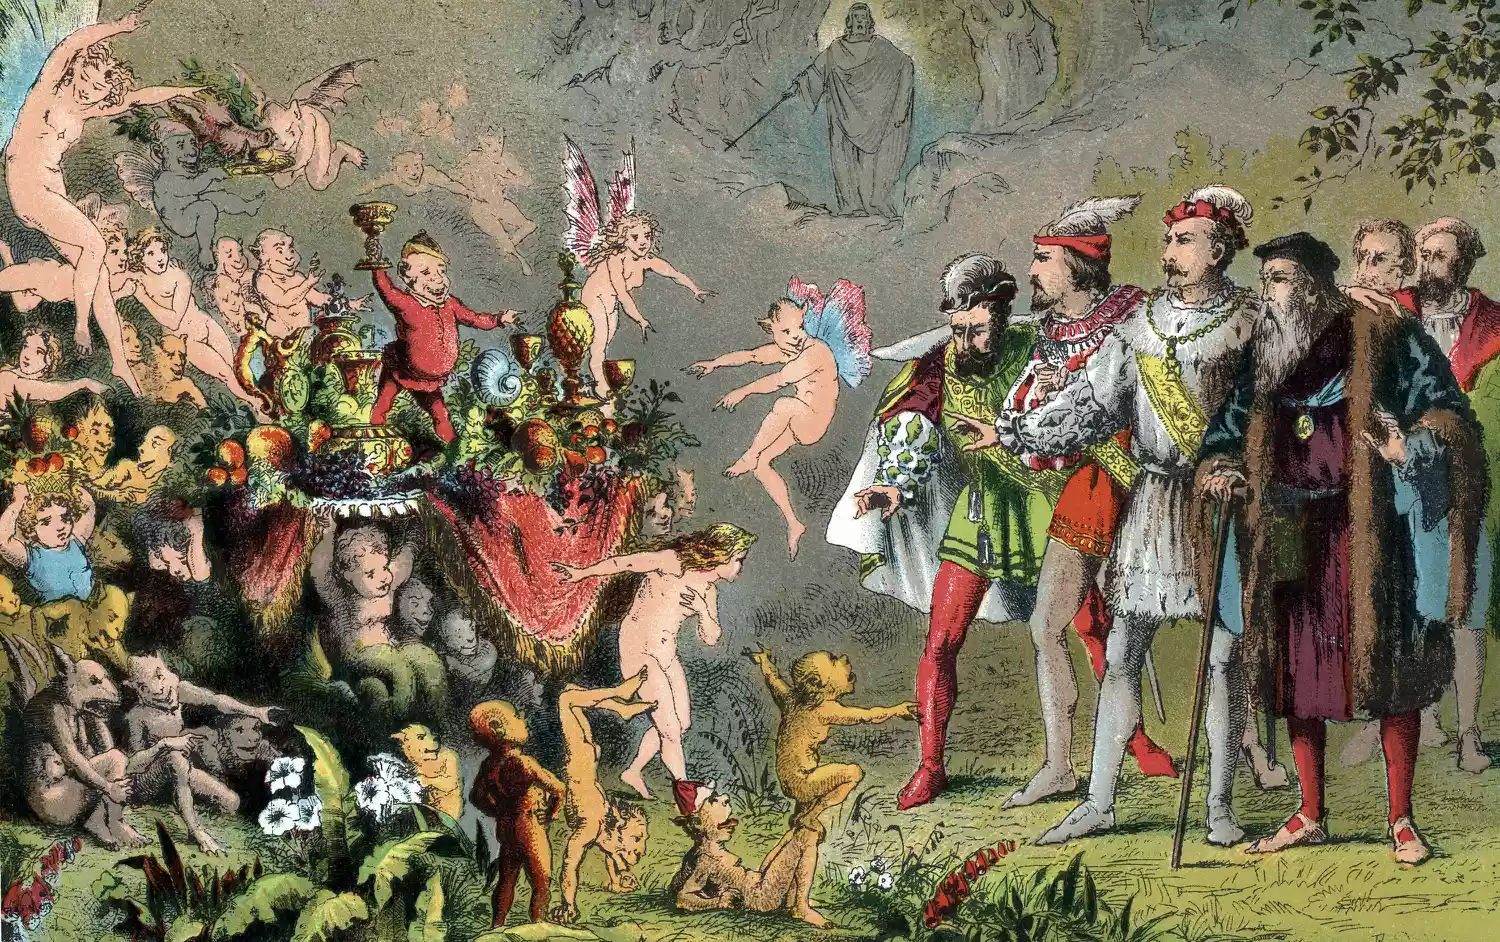

The play **The Tempest** by William Shakespeare is replete with intricate character relationships and emotional dynamics. This  project especially deploys social network analysis techniques to examine the emotional interactions between characters. By doing so, the aim is to cast new light on the structure of the play and character relationships, thus enhancing readers' understanding of the work through the data visualisation of social network analysis.



I created this project using two files: **the XML file of the Tempest** and **the EmoLex emotion dictionary**. I extracted the characters and their dialogues from the XML files and used the data to analyse the characters' social relationships based on emotions using the emotion dictionary.

The NRC-Emotion-Lexicon-Wordlevel-v0.92.txt file, an emotion lexicon, and the tempest.xml file of Shakespeare's play are attached for analysis.




*   The emotion lexicon : https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

*   The tempest.xml file : https://www.ibiblio.org/xml/examples/shakespeare/tempest.xml.



In [ ]:
from google.colab import files
import io
import os

uploaded = files.upload()

Saving NRC-Emotion-Lexicon-Wordlevel-v0.92.txt to NRC-Emotion-Lexicon-Wordlevel-v0.92 (1).txt
Saving tempest.xml to tempest (1).xml


In [ ]:
import numpy as np
import xml.etree.ElementTree as ET
import re
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

This code loads the NRC Emotion Lexicon and parses the ‘The Tempest’ XML file. The `load_emolex` function structures the emotion dictionary, and the `extract_emotions` function extracts and quantifies emotions from the text. This lays the foundation for the emotion analysis of the play.

In [ ]:
# EmoLex data load function
def load_emolex(file_content):
    emolex = defaultdict(lambda: defaultdict(float))
    for line in file_content.decode('utf-8').split('\n'):
        if line.strip():
            word, emotion, value = line.strip().split('\t')
            emolex[word][emotion] = float(value)
    return emolex

# EmoLex data load
emolex = load_emolex(uploaded['NRC-Emotion-Lexicon-Wordlevel-v0.92 (1).txt'])

# Parsing XML files
tree = ET.parse(io.BytesIO(uploaded['tempest (1).xml']))
root = tree.getroot()

acts = root.findall('ACT')

# Emotion word extraction function (using EmoLex)
def extract_emotions(speech, emolex):
    emotion_counts = defaultdict(float)
    words = re.findall(r'\b\w+\b', speech.lower())
    for word in words:
        if word in emolex:
            for emotion, value in emolex[word].items():
                emotion_counts[emotion] += value
    return emotion_counts

To make the characters' relationships more visible, I grouped them together and organised their political relationships based on the content of the play.


Based on the main characters, I divided them into three groups which are **'Prospero Group'**, **'Alonso Group'**, **'Caliban Group'** and coloured the groups for the nodes that describe each character. Lastly, I categorised each character into three main political relationships that are noticeable in the play.

In [ ]:
# Setting up main characters and groups
target_characters = {
    'Prospero Group': {'PROSPERO', 'MIRANDA', 'ARIEL'},
    'Alonso Group': {'ALONSO', 'FERDINAND', 'SEBASTIAN', 'ANTONIO', 'GONZALO'},
    'Caliban Group': {'CALIBAN', 'STEPHANO', 'TRINCULO'}
}

# Setting colours by group
group_colors = {
    'Prospero Group': '#44ABC2',
    'Alonso Group': '#F0C64B',
    'Caliban Group': '#92C308'
}

# Setting up political power relationships
relationships = {
    ('PROSPERO', 'ALONSO'): 'complex',
    ('PROSPERO', 'ANTONIO'): 'enemy',
    ('PROSPERO', 'MIRANDA'): 'ally',
    ('ALONSO', 'FERDINAND'): 'ally',
    ('ALONSO', 'SEBASTIAN'): 'complex',
    ('ALONSO', 'ANTONIO'): 'ally',
    ('CALIBAN', 'STEPHANO'): 'ally',
    ('CALIBAN', 'TRINCULO'): 'ally',
    ('FERDINAND', 'MIRANDA'): 'ally'
}

## 1. Key Character Networks

This visualisation illustrates the centrality of which characters have the most influence in each scene.




In [ ]:
# Speech extraction functions
def spkers(scene):
    scenespeakers = []
    for speech in scene.findall('.//SPEECH'):
        speaker = speech.find('SPEAKER').text.strip().upper()
        if any(speaker in group for group in target_characters.values()):
            scenespeakers.append(speaker)
    return scenespeakers

# Edge creation functions
def makeEdges(speakers_set):
    edg = []
    spnet = itertools.combinations(speakers_set, 2)
    for i in spnet:
        edg.append(i)
    return edg

# Network creation and visualization functions
def visualize_network(acts, target_characters, group_colors, relationships, emolex):
    all_scenes = [(act, scene) for act in acts for scene in act.findall('.//SCENE')]
    n_plots = len(all_scenes)
    rows = (n_plots + 1) // 2

    fig, axs = plt.subplots(rows, 2, figsize=(28, 14*rows))
    fig.suptitle('Key Character Network', fontsize=16)

    for idx, (act, scene) in enumerate(all_scenes):
        row = idx // 2
        col = idx % 2
        ax = axs[row, col] if rows > 1 else axs[col]

        act_title = act.find('TITLE').text if act.find('TITLE') is not None else "Unknown Act"
        scene_title = scene.find('TITLE').text if scene.find('TITLE') is not None else "Unknown Scene"

        speakers = spkers(scene)
        speakersSet = list(sorted(set(speakers)))
        personae = sorted(set(speaker for speaker in speakersSet if any(speaker in group for group in target_characters.values())))

        dialogue_counts = {person: 0 for person in personae}
        for speaker in speakers:
            if speaker in personae:
                dialogue_counts[speaker] += 1

        emotion_usage = defaultdict(lambda: defaultdict(float))
        for speech in scene.findall('.//SPEECH'):
            speaker = speech.find('SPEAKER').text.strip().upper()
            if speaker in personae:
                speech_text = ' '.join(line.text for line in speech.findall('LINE') if line.text)
                emotion_counts = extract_emotions(speech_text, emolex)
                for emotion, value in emotion_counts.items():
                    emotion_usage[speaker][emotion] += value

        G = nx.Graph()
        G.add_nodes_from(personae)

        edg = makeEdges(personae)
        G.add_edges_from(edg)

        for (char1, char2), relation in relationships.items():
            if char1 in G.nodes() and char2 in G.nodes():
                if relation == 'ally':
                    G.add_edge(char1, char2, relation=relation, color='blue', weight=2)
                elif relation == 'enemy':
                    G.add_edge(char1, char2, relation=relation, color='red', weight=2)
                elif relation == 'complex':
                    G.add_edge(char1, char2, relation=relation, color='purple', weight=2)
                else:
                    G.add_edge(char1, char2, relation=relation, color='gray', weight=1)

        pos = nx.spring_layout(G, k=2, scale=1, iterations=120)

        for node in G.nodes():
            node_color = 'gray'
            for group, members in target_characters.items():
                if node in members:
                    node_color = group_colors[group]
                    break

            dialogue_size = dialogue_counts[node] * 200
            emotion_size = sum(emotion_usage[node].values()) * 50
            node_size = dialogue_size + emotion_size

            alpha = min(1, max(0.1, dialogue_counts[node] / max(dialogue_counts.values())))
            nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=node_size, node_color=node_color, alpha=alpha, ax=ax)

        edges = G.edges(data=True)
        colors = [edge[2].get('color', 'gray') for edge in edges]
        weights = [edge[2].get('weight', 1) for edge in edges]
        nx.draw_networkx_edges(G, pos, edge_color=colors, width=weights, ax=ax)

        edge_labels = nx.get_edge_attributes(G, 'relation')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)

        nx.draw_networkx_labels(G, pos, ax=ax)
        ax.set_title(f'{act_title}, {scene_title}')
        ax.axis('off')

    if n_plots % 2 != 0:
        fig.delaxes(axs[rows-1, 1])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.1)
    plt.show()

The size, transparency, and colour of a character's nodes indicate their importance and political relationships in each scene.

- Size: Size is proportional to the number of dialogues a character has, which means the more dialogues, the larger the size. Size is also proportional to the sum of all emotional intensity, so the more emotions expressed or the stronger a particular emotion, the larger the size. The resulting `node_size` is the sum of both of these factors.

- Transparency: Transparency is a function of dialogue, with more dialogue being more opaque and less being more transparent. This visually emphasises characters who appear more often or play an important role in the play.

- Colours: All character nodes have a colour for each group. In addition, political relationships between characters are easily recognisable through the colour of their edges, and the brightness of the node indicates its importance in each character's political relationships.

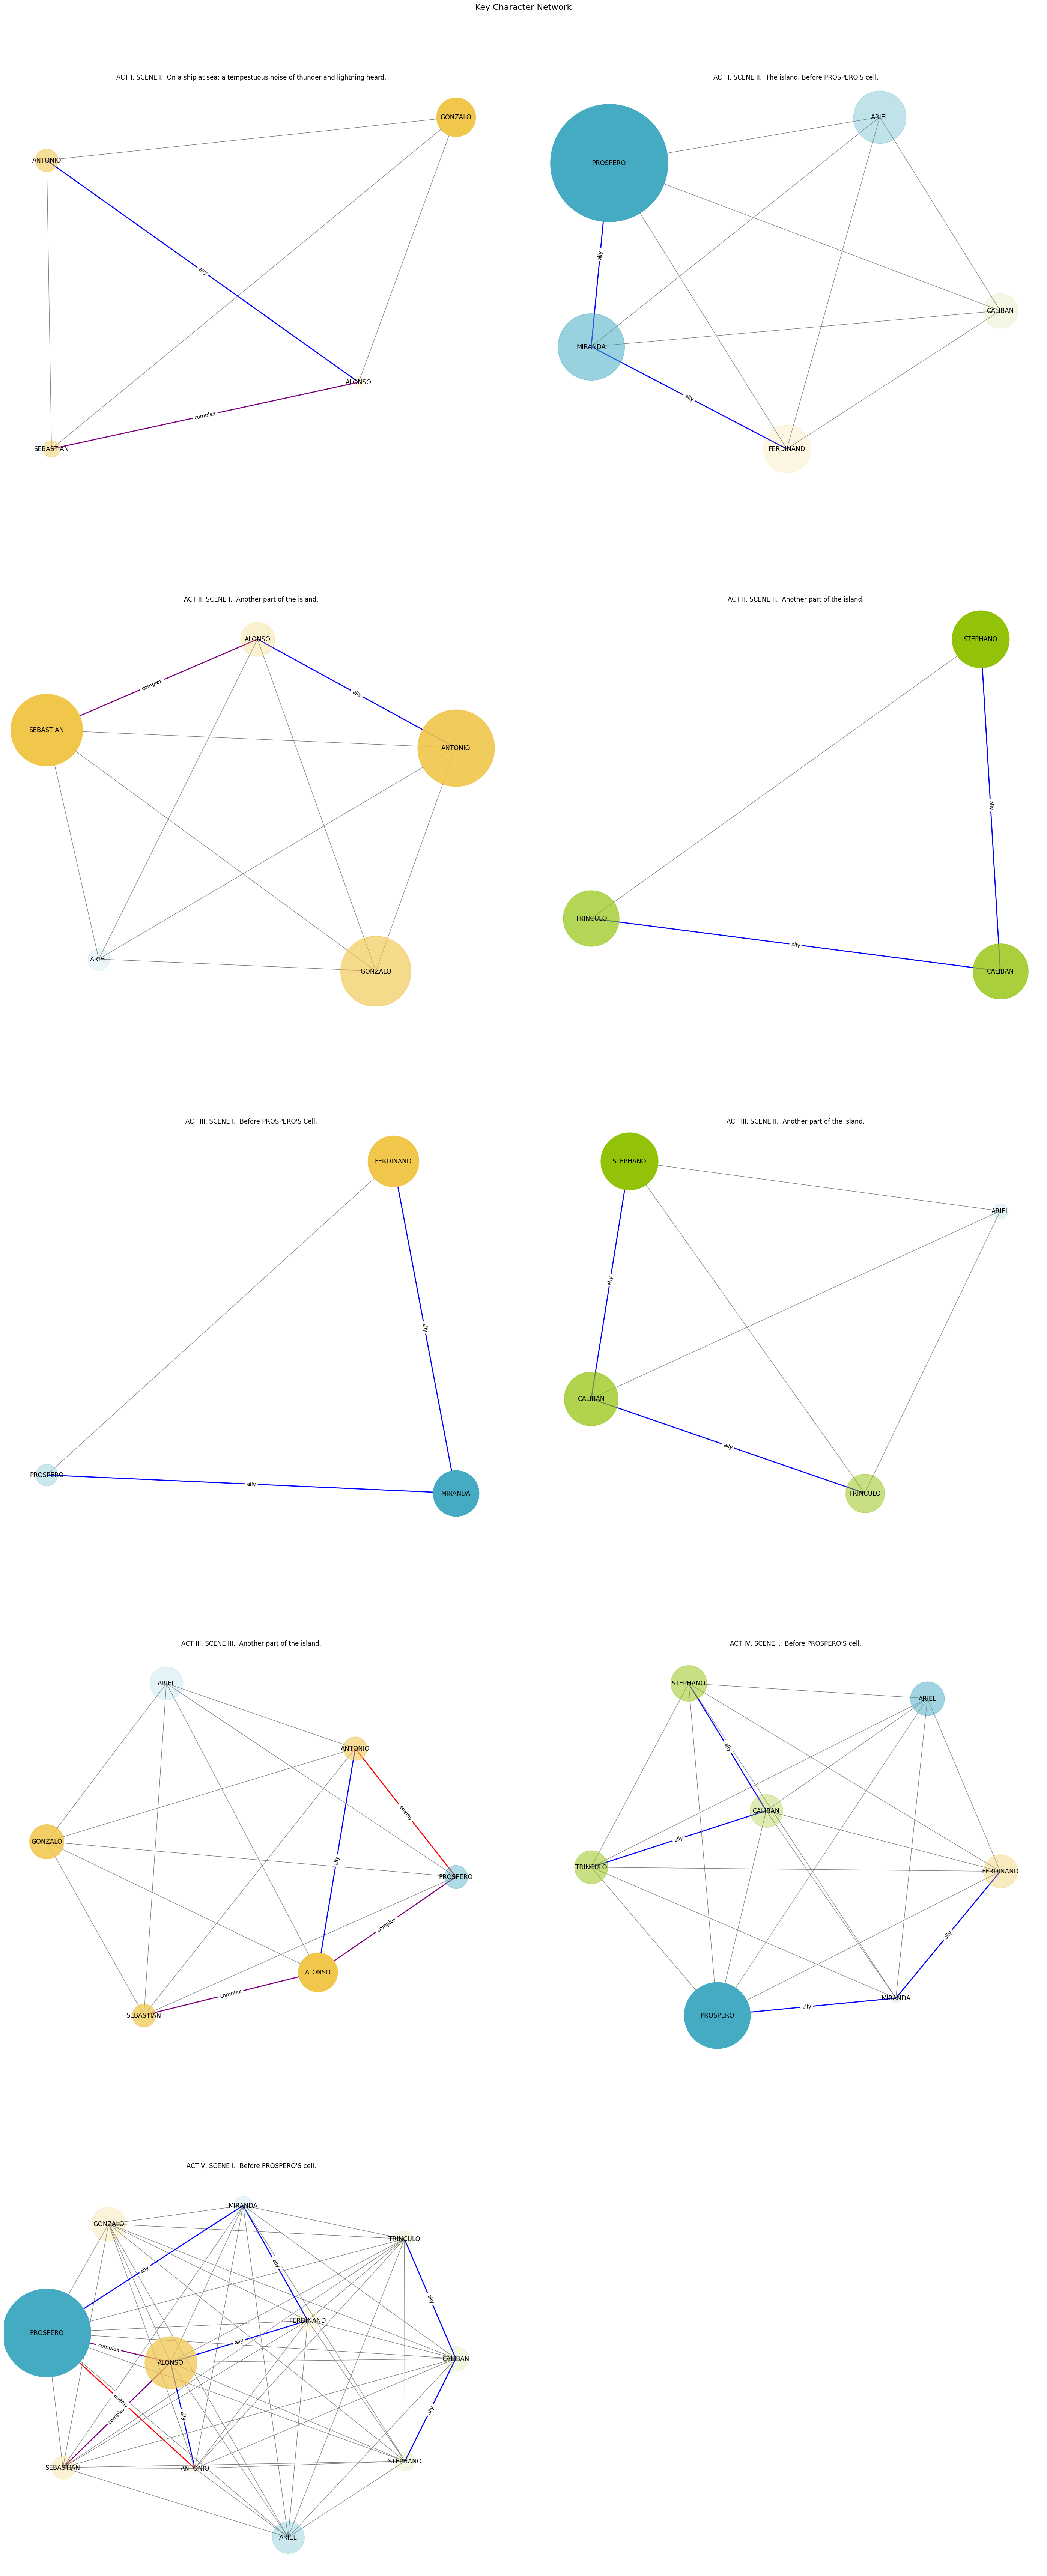

In [ ]:
visualize_network(acts, target_characters, group_colors, relationships, emolex)

## 2. Emotion-Weighted Character Network

A emotion-weighted network provides a more detailed understanding of the relationships between characters. This network facilitates the understanding of relationships between characters based on the emotions they share.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict

def calculate_emotion_weight(emotion_usage, char1, char2):
    emotions1 = emotion_usage.get(char1, {})
    emotions2 = emotion_usage.get(char2, {})

    similarity = sum(min(emotions1.get(e, 0), emotions2.get(e, 0)) for e in set(emotions1) | set(emotions2))
    intensity = sum(emotions1.values()) + sum(emotions2.values())

    return similarity * intensity

def get_shared_emotions(emotion_usage, char1, char2, top_n=2):
    emotions1 = emotion_usage.get(char1, {})
    emotions2 = emotion_usage.get(char2, {})

    shared_emotions = {}
    for emotion in set(emotions1) & set(emotions2):
        shared_emotions[emotion] = min(emotions1[emotion], emotions2[emotion])

    return sorted(shared_emotions.items(), key=lambda x: x[1], reverse=True)[:top_n]

def analyze_emotions(acts, emolex, target_characters):
    all_data = []
    for act in acts:
        act_title = act.find('TITLE').text if act.find('TITLE') is not None else "Unknown Act"
        for scene in act.findall('.//SCENE'):
            scene_title = scene.find('TITLE').text if scene.find('TITLE') is not None else "Unknown Scene"
            for speech in scene.findall('.//SPEECH'):
                speaker = speech.find('SPEAKER').text.strip().upper()
                if any(speaker in group for group in target_characters.values()):
                    speech_text = ' '.join(line.text for line in speech.findall('LINE') if line.text)
                    emotion_counts = extract_emotions(speech_text, emolex)
                    row = {
                        'Act': act_title,
                        'Scene': scene_title,
                        'Character': speaker,
                        **emotion_counts
                    }
                    all_data.append(row)
    return pd.DataFrame(all_data)

def visualize_emotion_weighted_network(df, target_characters, group_colors, relationships):
    acts_scenes = df.groupby(['Act', 'Scene'])
    n_plots = len(acts_scenes)
    rows = (n_plots + 1) // 2

    fig, axs = plt.subplots(rows, 2, figsize=(24, 16*rows))
    fig.suptitle('Emotion-Weighted Character Network', fontsize=18)

    for idx, ((act, scene), group_data) in enumerate(acts_scenes):
        row = idx // 2
        col = idx % 2
        ax = axs[row, col] if rows > 1 else axs[col]

        G = nx.Graph()

        characters = group_data['Character'].unique()
        G.add_nodes_from(characters)

        emotion_usage = {char: dict(group_data[group_data['Character'] == char][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']].sum()) for char in characters}

        edge_labels = {}
        edge_info = []
        for char1 in characters:
            for char2 in characters:
                if char1 != char2:
                    weight = calculate_emotion_weight(emotion_usage, char1, char2)
                    if weight > 0:
                        G.add_edge(char1, char2, weight=weight)

        # add political power relationships
        for (char1, char2), relation in relationships.items():
            if char1 in G.nodes() and char2 in G.nodes():
                G.add_edge(char1, char2, relation=relation)

        edge_weights = [G[u][v]['weight'] for u, v in G.edges() if 'weight' in G[u][v]]
        avg_weight = np.mean(edge_weights) if edge_weights else 0
        max_weight = max(edge_weights) if edge_weights else 1

        thick_edge_threshold = avg_weight * 1.5

        edge_widths = []
        for u, v in G.edges():
            if 'weight' in G[u][v]:
                weight = G[u][v]['weight']
                if weight > thick_edge_threshold:
                    width = 4
                    shared_emotions = get_shared_emotions(emotion_usage, u, v)
                    edge_label = '\n'.join([f"{e}: {v:.1f}" for e, v in shared_emotions])
                    edge_labels[(u, v)] = edge_label
                    edge_info.append(f"{u} - {v}: {edge_label}")
                else:
                    width = 1 + (weight / max_weight) * 2
            else:
                width = 2  # basic edge width
                edge_labels[(u, v)] = G[u][v]['relation']
                edge_info.append(f"{u} - {v}: {G[u][v]['relation']}")
            edge_widths.append(width)

        pos = nx.spring_layout(G, k=0.5, iterations=70)

        for group, members in target_characters.items():
            nx.draw_networkx_nodes(G, pos, nodelist=[node for node in G.nodes() if node in members],
                                   node_color=group_colors[group], node_size=700, alpha=0.8, ax=ax)

        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, ax=ax)

        nx.draw_networkx_labels(G, pos, font_size=11, font_family='sans-serif', ax=ax)

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

        ax.set_title(f'{act}, {scene}', fontsize=12)
        ax.set_frame_on(True)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(2)

        ax.text(0.5, -0.1, '\n'.join(edge_info), transform=ax.transAxes, fontsize=12,
                verticalalignment='top', horizontalalignment='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    if n_plots % 2 != 0:
        fig.delaxes(axs[rows-1, 1])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.5, wspace=0.1)
    plt.show()

When there is a strong connection between two characters for a particular emotion across the eight emotions in the emotion dictionary (**‘anger’, ‘expectation’, ‘disgust’, ‘fear’, ‘joy’, ‘sadness’, ‘surprise’, ‘trust’**), the character nodes are represented by special edges connecting them together.


This is done by calculating an emotion weight for each pair of characters, which is visualised on the edge when the agreement for a particular emotion between two characters exceeds the average weight. This is done by calculating an emotion weight for each pair of characters, which is visualised on the edge when the agreement for a particular emotion between two characters exceeds the average weight. For these strong emotional connections, the edge will be **thicker** and will **display text with information about the main emotion shared by the character pair**.


For example, in **ACT III, SCENE I**, *MIRANDA* and *FERDINAD*, who belong to different groups, share `15 of the emotion ‘trust’` and `13 of the emotion ‘joy’`. This suggests that the two characters from different groups have a positive relationship with each other. indeed they are portrayed as lovers in the play.

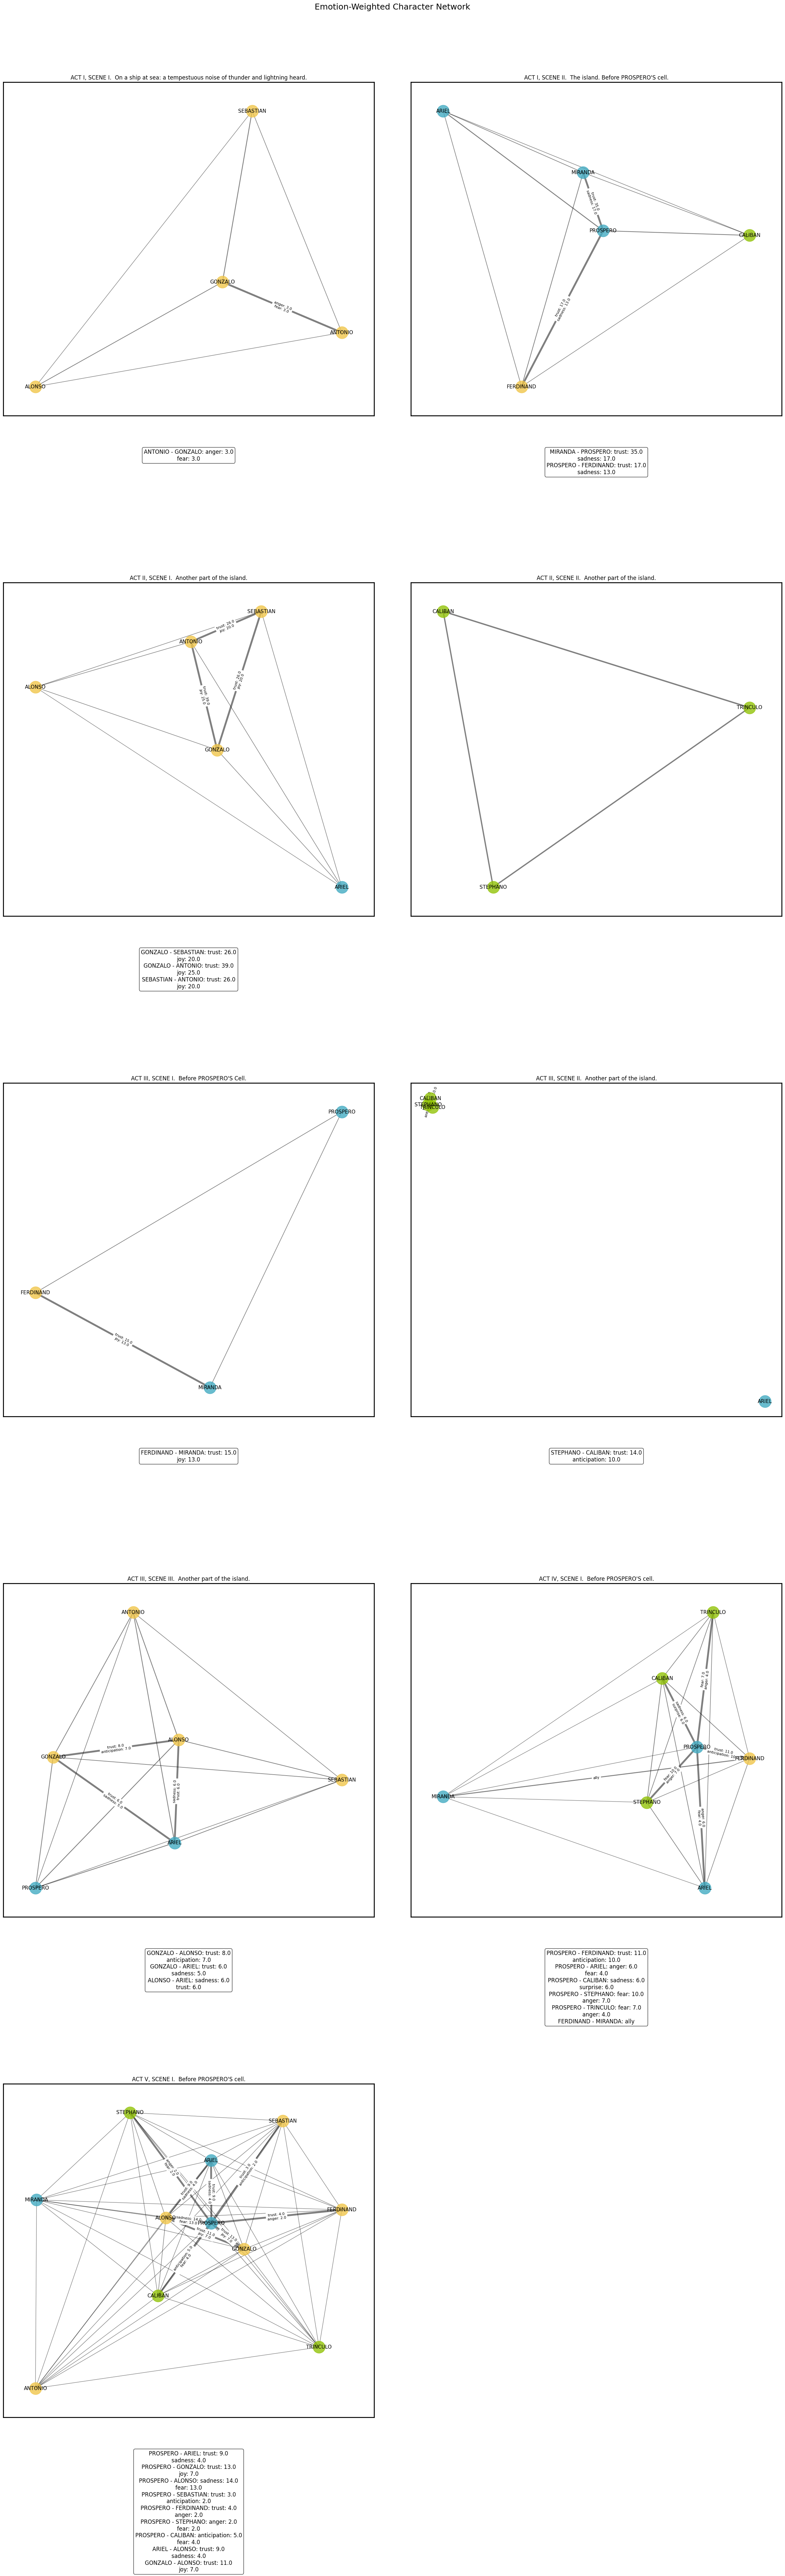

In [ ]:
visualize_emotion_weighted_network(df, target_characters, group_colors, relationships)

Emotions in literature often mirror real-life complexities. Analyzing character emotions in famous plays enhances our understanding of the story and can improve our real-world interactions. In this project, I analyzed "The Tempest" to find important characters and main emotions in its social network. I used two ways to analyze the networks:

1. Key Character Networks:
   - I found which characters have the most connections (centrality)
   - I saw which characters form close groups (community structure)

2. Emotion-Weighted Character Networks:
   - I found which relationships have the strongest emotions
   - I saw which characters have many different emotional connections

Interestingly, such analysis could provide valuable data for AI to comprehend human emotions more deeply. Theatrical texts, with their dramatic emotional shifts, offer richer emotional data compared to everyday language, potentially aiding AI in developing a nuanced understanding of human feelings.



---



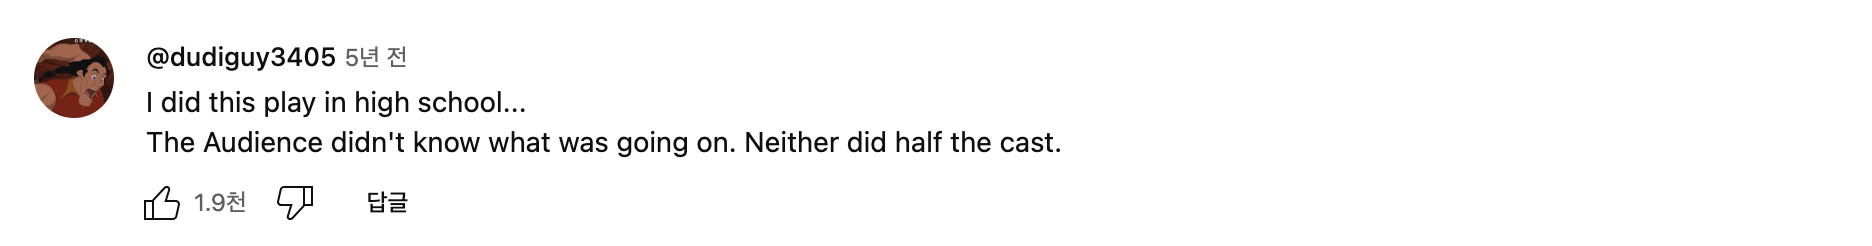

I found this comment on youtube(Why should you read Shakespeare’s “The Tempest”? [Link](https://www.youtube.com/watch?v=UvznOeSyESU)). It shows that plays can be difficult to understand. Therefore, this analysis can help people understand the play better by clearly showing the complex relationships and emotions. It can help both the audience and the actors to understand the story more deeply.

Ultimately, these network analysis methods can be useful tools. Because they can help us understand stories better, learn about real-life relationships, and even help AI understand emotions better.